# Régression logistique

Prédire la couleur d'un vin à partir de ses composants.

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_wines_dataset
data = load_wines_dataset()
X = data.drop(['quality', 'color'], axis=1)
y = data['color']

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression()
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

La première façon de vérifier que le modèle a marché consiste à regarder la matrice de confusion.

In [5]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test, clr.predict(X_test))
conf

array([[ 396,   22],
       [  12, 1195]], dtype=int64)

Les coefficients sur la diagonale indique les éléments bien classés, les coefficients en dehors ceux que le classifieur a mis dans la mauvaise classe.

In [6]:
import pandas
cf = pandas.DataFrame(conf, columns=['prédit ' + _ for _ in clr.classes_])
cf.index = ['vrai ' + _ for _ in clr.classes_]
cf

,prédit red,prédit white
vrai red,396,22
vrai white,12,1195


Un classifieur construit une frontière entre deux classes, la distance d'un point à la frontière consistue une information importante. Plus elle est grande, plus le modèle est confiant. Cette distance est souvent appelée *score*.

In [7]:
clr.decision_function(X_test)

array([ 4.97076602, -4.12385392,  4.82012019, ...,  3.97300735,
        9.10196458,  3.15922227])

Mais on préfère les probabilités quand elles sont disponibles :

In [8]:
clr.predict_proba(X_test)

array([[6.89002962e-03, 9.93109970e-01],
       [9.84075658e-01, 1.59243418e-02],
       [8.00128074e-03, 9.91998719e-01],
       ...,
       [1.84692283e-02, 9.81530772e-01],
       [1.11434229e-04, 9.99888566e-01],
       [4.07294292e-02, 9.59270571e-01]])

Voyons comment le score est distribué :

In [9]:
score = clr.decision_function(X_test)
dfsc = pandas.DataFrame(score, columns=['score'])
dfsc['color'] = y_test
dfsc.head()

,score,color
0,4.970766,NaN
1,-4.123854,NaN
2,4.820120,NaN
3,6.314685,NaN
4,3.904799,NaN


Visiblement, pandas n'a pas compris ce que je voulais qu'il fasse. Il a utilisé les indices de la série *y_test* et a utilisé *y_test.index* comme indice de tableau. Changeons cela.

In [10]:
dfsc = pandas.DataFrame(score, columns=['score'])
dfsc['color'] = y_test.as_matrix()
dfsc.head()

,score,color
0,4.970766,white
1,-4.123854,red
2,4.820120,white
3,6.314685,white
4,3.904799,white


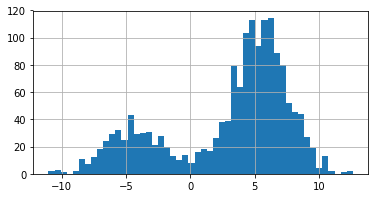

In [11]:
dfsc['score'].hist(bins=50, figsize=(6,3))

Deux modes, probablement les deux classes. Pour en être sûr :

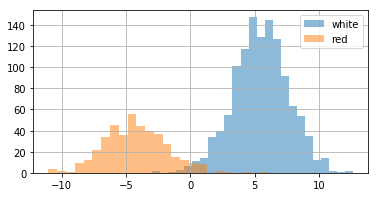

In [12]:
ax = dfsc[dfsc['color'] == 'white']['score'].hist(bins=25, figsize=(6,3), label='white', alpha=0.5)
dfsc[dfsc['color'] == 'red']['score'].hist(bins=25, ax=ax, label='red', alpha=0.5)
ax.legend();

Il y a quelques confusions autour de 0 mais le modèle est pertinent au sens où la frontière entre les deux classes est assez nette : les deux cloches ne se superposent pas. Voyons avec les probabilités :

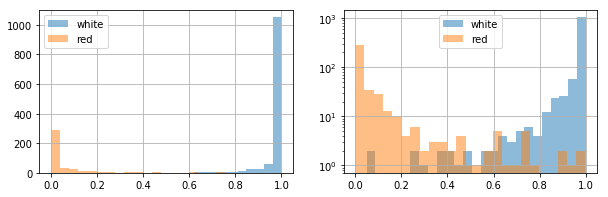

In [13]:
proba = clr.predict_proba(X_test)[:, 1]
dfpr = pandas.DataFrame(proba, columns=['proba'])
dfpr['color'] = y_test.as_matrix()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,3))
dfpr[dfpr['color'] == 'white']['proba'].hist(bins=25, label='white', alpha=0.5, ax=ax[0])
dfpr[dfpr['color'] == 'red']['proba'].hist(bins=25, label='red', alpha=0.5, ax=ax[0])
ax[0].legend();
dfpr[dfpr['color'] == 'white']['proba'].hist(bins=25, label='white', alpha=0.5, ax=ax[1])
dfpr[dfpr['color'] == 'red']['proba'].hist(bins=25, label='red', alpha=0.5, ax=ax[1])
ax[1].set_yscale('log')
ax[1].legend();

Plus l'aire commune aux deux distributions est petite, plus le modèle est confiant. Cette aire commune est reliée à la courbe [ROC](https://fr.wikipedia.org/wiki/Courbe_ROC).

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
probas = clr.predict_proba(X_test)
fpr0, tpr0, thresholds0 = roc_curve(y_test, probas[:, 0], pos_label=clr.classes_[0], drop_intermediate=False)
fpr0.shape

(1530,)

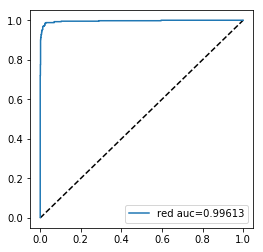

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
# aucf = roc_auc_score(y_test == clr.classes_[0], probas[:, 0]) # première façon
aucf = auc(fpr0, tpr0)  # seconde façon
ax.plot(fpr0, tpr0, label=clr.classes_[0] + ' auc=%1.5f' % aucf)
ax.legend();

La mesure [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) ou Area Under the Curve est l'aire sous la courbe. Elle est égale à la probabilité que le score d'un exemple classé rouge à raison soit inférieur à un exemple classé rouge à tort. On vérifie.

In [16]:
from random import randint
n1, n2 = 0, 0
yt = y_test.as_matrix()

for n in range(0, 100000):
    i = randint(0, len(yt)-1)
    j = randint(0, len(yt)-1)
    s1, p1 = probas[i, 0], yt[i] == clr.classes_[0]
    s2, p2 = probas[j, 0], yt[j] == clr.classes_[0]
    if p1 != p2:
        if p1:
            if s1 < s2:
                n1 += 1
            else:
                n2 += 1
        else:
            if s1 > s2:
                n1 += 1
            else:
                n2 += 1
print(n2*1.0/(n1 + n2))

0.9963483515040064


Presque cela, la fonction [auc]() utilise la fontion [trapz](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.trapz.html) et qui calcule une aire et non pas une probabilité comme-ci dessus. Voyons ce qu'il se passe en général si nous décidons non pas d'évaluer un modèle qui classifie bien une classe mais les deux classes à la fois. La différence est subtile. Le score est celui de la classe prédite et non plus celui d'une classe.

In [17]:
list_classes = list(clr.classes_)

pred = clr.predict(X_test)
scores = clr.decision_function(X_test)
pred_i = [list_classes.index(c) for c in pred]
probas = clr.predict_proba(X_test)
proba = [probas[i, c] for i, c in enumerate(pred_i)]
score = [scores[i] if c == 0 else -scores[i]  for i, c in enumerate(pred_i)]

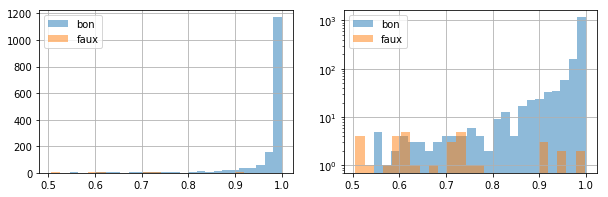

In [18]:
dfpr = pandas.DataFrame(proba, columns=['proba'])
dfpr['color'] = y_test.as_matrix()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,3))
dfpr[pred == dfpr['color']]['proba'].hist(bins=25, label='bon', alpha=0.5, ax=ax[0])
dfpr[pred != dfpr['color']]['proba'].hist(bins=25, label='faux', alpha=0.5, ax=ax[0])
ax[0].legend();
dfpr[pred == dfpr['color']]['proba'].hist(bins=25, label='bon', alpha=0.5, ax=ax[1])
dfpr[pred != dfpr['color']]['proba'].hist(bins=25, label='faux', alpha=0.5, ax=ax[1])
ax[1].set_yscale('log')
ax[1].legend();

Et avec les scores et non plus les probabilités.

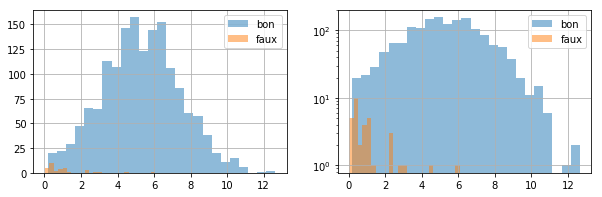

In [19]:
scores = clr.decision_function(X_test)
dfsc = pandas.DataFrame(scores, columns=['score'])
dfsc.loc[pred == 'red', 'score'] *= -1
dfsc['color'] = y_test.as_matrix()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,3))
dfsc[pred == dfsc['color']]['score'].hist(bins=25, label='bon', alpha=0.5, ax=ax[0])
dfsc[pred != dfsc['color']]['score'].hist(bins=25, label='faux', alpha=0.5, ax=ax[0])
ax[0].legend();
dfsc[pred == dfsc['color']]['score'].hist(bins=25, label='bon', alpha=0.5, ax=ax[1])
dfsc[pred != dfsc['color']]['score'].hist(bins=25, label='faux', alpha=0.5, ax=ax[1])
ax[1].set_yscale('log')
ax[1].legend();

In [20]:
fpr, tpr, thresholds = roc_curve(pred == y_test, proba)

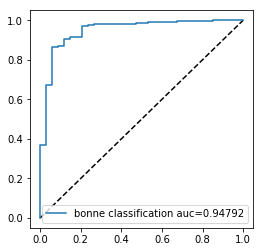

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)  # seconde façon
ax.plot(fpr, tpr, label='bonne classification auc=%1.5f' % aucf)
ax.legend();

In [22]:
n1, n2 = 0, 0
yt = y_test.as_matrix()

for n in range(0, 100000):
    i = randint(0, len(yt)-1)
    j = randint(0, len(yt)-1)
    
    s1, p1 = proba[i], yt[i] == pred[i]
    s2, p2 = proba[j], yt[j] == pred[j]
    if p1 != p2:
        if p1:
            if s1 < s2:
                n1 += 1
            else:
                n2 += 1
        else:
            if s1 > s2:
                n1 += 1
            else:
                n2 += 1
print(n2*1.0/(n1 + n2))

0.9489598451862603


Mais pourquoi les résultats sont-ils moins bons ?